Our prediction target for the regression is the mass attribute, as we stated it in our previous report. The mass will be predicted based on the following attributes: distance, stellar_magnitude, orbital_radius, orbital_period, eccentricity and radius attributes. This choice is based on our previous analysis and research of the dataset where we found that the mass could potentially have a high importance in predicting the planet type which we predict for our classification task.
Sources: 
- https://www.kaggle.com/code/suhanikulshrestha02/exoplanet-characterization-using-ml
- https://www.kaggle.com/code/mikedelong/looking-for-earth-like-planets-with-scatter-plots

Additionally, the mass attribute was found to be less correlated with other variables than most other attributes (e.g. orbital period and orbital radius) which makes it a more interesting target for our Neural Network regression.
[Correlation Matrix relevant part could be added...]

In order to make our data suitable for regression tasks, we needed to do a few transformations. First of all, the mass attribute was stored in 2 separate attributes: mass_wrt, and mass_multiplier. This way the mass was always stored relative to Earth or Jupiter in the original dataset. To unify this, we converted the masses to kg and created a single mass variable. The same process was repeated for the radius_multiplier and radius_wrt attributes.

Some attributes were excluded, as their meaning is not clear for such a task: Even though detection_method, and discovery_year is part of our attribute list, it is not aligned with our objective as it is not a planetary characteristic, more of an artifact of the observation and categorization. Because of this reason such variables were considered to be irrelevant for this task.
Moreover the attribute orbital_period was also excluded from the list of attributes because of its extreme correlation with orbital_radius. Based on some test runs with including this attribute we found that this makes the model unstable, possibly due to both of the attributes pushing the model in the same direction and distorting the importance of the features.

We decided to include planet_type in our attributes, as it can serve as a useful indicator of the plant properties. We needed to transform this variable because of its categorical nature. For this we used one of K encoding, so that each planet type has its own column in the data.


After these preparatory steps we standardized the data. It is important to highlight here that for the regression task both our features and our target variable was standardized. This choice was based on the scale of our mass attribute, which due to being calculated in kg-s, moves around the range of 10^20. This can lead into anomalies during the training (calculations with such numbers could more easily lead into overflows). We made sure to only standardize the numerical attributes, and leave the one of K encoded planet types as is.
Wherever we used cross-validation, we made sure to do the standardization for each fold separately, to get accurate and fair results for the model.

Another important point is that the training and validation data has been standardized separately. This is to make sure that no information from the validation set leaks into the training set, which could happen if we standardize the whole dataset beforehand. In such scenario the mean and the variance is calculated on the whole dataset too which includes the samples from the validation set. Thus the model would be able to access this information indirectly based on the new scale of the training data.

Our aim is to compare multiple methods for the regression task to see which one performs the best. Whenever we evaluate the optimal model, we use a separate validation set.
First, we ran a linear regression model with a 10 fold cross validation setup to see if it can capture the relationship between the data. Our goal



In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [77]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [78]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [79]:
columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
for col in columns_to_log:
    df[col] = np.log10(df[col])

In [80]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

In [81]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [82]:
df_train = df_without_type.copy().drop("orbital_period", axis=1)
df_train["planet_type"] = df["planet_type"]
df_train = pd.get_dummies(df_train, columns=['planet_type'])

df_train

,distance,stellar_magnitude,orbital_radius,eccentricity,mass,radius,planet_type_Gas Giant,planet_type_Neptune-like,planet_type_Super Earth,planet_type_Terrestrial
0,2.482874,4.72307,0.110590,0.23,28.566098,4.877969,True,False,False,False
1,2.611723,5.01300,0.184691,0.08,28.446794,4.881972,True,False,False,False
2,2.390935,5.23133,-0.080922,0.00,27.959537,4.905243,True,False,False,False
3,1.763428,6.61935,0.442961,0.37,28.188857,4.893764,True,False,False,False
4,1.838849,6.21500,0.220108,0.68,27.528716,4.923727,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
4260,3.894814,16.06200,-0.970616,0.00,25.689934,4.240745,False,True,False,False
4261,3.504743,14.67200,-0.994391,0.00,25.673747,4.231935,False,True,False,False
4262,3.468643,15.57600,-0.941574,0.00,25.626153,4.202480,False,True,False,False
4263,3.556423,15.42400,-0.897566,0.00,25.673747,4.231935,False,True,False,False


In [83]:
# Define features, and target variable
X = df_train.drop(columns=['mass']).values
y = df_train['mass'].values
print(X.shape, y.shape)

(4000, 9) (4000,)


In [84]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def standardize_data(X_train_orig, X_test_orig, y_train_orig, y_test_orig, numerical_indices, encoded_indices):

    # Scale Numerical Features
    X_train_numerical = X_train_orig[:, numerical_indices]
    X_test_numerical = X_test_orig[:, numerical_indices]

    feature_scaler = StandardScaler()
    X_train_scaled_numerical = feature_scaler.fit_transform(X_train_numerical)
    X_test_scaled_numerical = feature_scaler.transform(X_test_numerical)

    # Recombine scaled numerical + encoded parts
    X_train_scaled = np.concatenate([X_train_scaled_numerical, X_train_orig[:, encoded_indices]], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numerical, X_test_orig[:, encoded_indices]], axis=1)

    # Scale Target Variable
    mu_y = y_train_orig.mean()
    sigma_y = y_train_orig.std()
    epsilon = 1e-8

    y_train_scaled = (y_train_orig - mu_y) / (sigma_y + epsilon)
    y_test_scaled = (y_test_orig - mu_y) / (sigma_y + epsilon)

    return X_train_scaled.astype(np.float32), X_test_scaled.astype(np.float32), y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y


In [85]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [86]:
lambdas = np.logspace(-2, 2, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [87]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler # Import the scaler

# Define column indices
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# A safety check in case there are no numerical columns
has_numerical_features = len(numerical_indices) > 0

for lam in lambdas:
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize processed arrays with the one-hot encoded parts
        X_train, X_test, y_train, y_test, a, b, c = standardize_data(
            X_train, X_test, y_train, y_test,
            numerical_indices, encoded_indices
        )

        # Fit the model on the correctly processed data
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)

In [88]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")

Optimal lambda = 1.1498
Minimum Cross-Validation error = 0.1050
Optimal coefficients = [ 0.04229772 -0.04607036  0.13807684  0.04762714  0.5509824   0.5454079
 -0.09262317 -0.06220103 -0.392648  ]


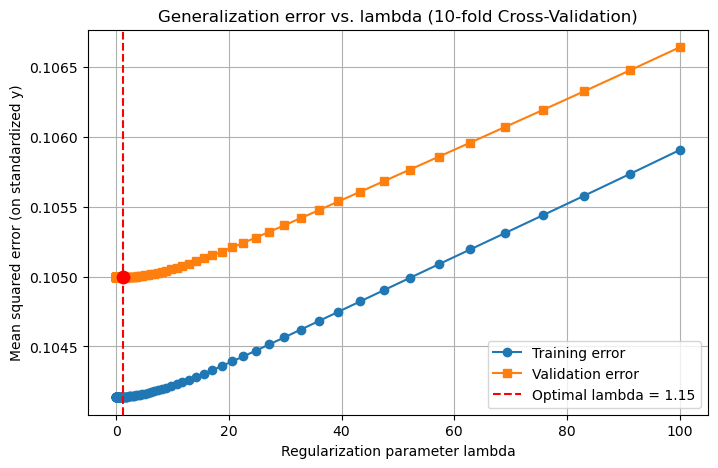

In [89]:

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Validation error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

As visible on the plot the linear regression model fails to capture the validation data as well as the train data. There is a visible difference on the validation and the training error. This indicates overfitting on the training set, as the model is not able to generalize the knowledge to the validation set, this means that the parameters of the model are tuned to the data it was trained on. 

Our conclusion is that linear regression is not the best approach for our problem.
This is a logical result when we look deeper into the attributes: The mass is not in a linear relationship with the other attributes. As it is also stated in Kepler's laws (which can be used for planet mass estimation if there is a moon or a spacecraft in orbit of the planet): https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion the relationship between some of these attributes is already quadratic or third degree. Additionally, there is no clear equation that would describe the relationships between our input and target attributes directly.

At the same time it is also observable that regularization helps with limiting the generalization error. As we increase lambda, the generalization error drops, then starts increasing while the training error steadily increases as we include higher and higher lambdas. This is a direct consequence of how regularization is applied, as it "forces" the weights away from the overfitting solution. However, if the lambda parameter is too high, it prevents the model from capturing the data ans the proportion of the regularization penalty in the error becomes the dominant factor.
[Formula for regularization]

Linear regression aims to fit a linear combination of the input features to capture the output feature: f(x,w) = w0 +
w1x1+· · ·+wMxM.
Now we go deeper into our optimal linear model by looking at the coefficients. These show how the individual attributes are weighted in the linear regression model.

In [90]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the column indices for numerical and encoded features
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# Isolate the numerical parts from the new splits
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y = standardize_data(
    X_train_orig, X_test_orig, y_train_orig, y_test_orig,
    numerical_indices, encoded_indices
)


print("--- Final Model Training ---")
print(f"Using optimal lambda: {optimal_lambda}")

# Initialize the model with the best lambda
ridge = Ridge(alpha=optimal_lambda)
ridge.fit(X_train_scaled, y_train_scaled)

# Store the final coefficients and intercept
coeffs = ridge.coef_
intercept = ridge.intercept_

# Make predictions on the scaled training and test sets
y_pred_train_scaled = ridge.predict(X_train_scaled)
y_pred_test_scaled = ridge.predict(X_test_scaled)

train_error_scaled = mean_squared_error(y_train_scaled, y_pred_train_scaled)
test_error_scaled = mean_squared_error(y_test_scaled, y_pred_test_scaled)

print(f"\nFinal training MSE (on scaled data): {train_error_scaled:.4f}")
print(f"Final test MSE (on scaled data): {test_error_scaled:.4f}")
print(f"\nModel Coefficients: {coeffs}")
print(f"Model Intercept: {intercept}")

--- Final Model Training ---
Using optimal lambda: 1.149756995397737

Final training MSE (on scaled data): 0.1013
Final test MSE (on scaled data): 0.1151

Model Coefficients: [ 0.0364276  -0.03546968  0.13195463  0.04532364  0.58490944  0.50191927
 -0.10112419 -0.05564018 -0.34329852]
Model Intercept: -0.05976938083767891


Ridge Regression Coefficients:
                 Feature  Coefficient
                  radius     0.584909
   planet_type_Gas Giant     0.501919
 planet_type_Terrestrial    -0.343299
          orbital_radius     0.131955
planet_type_Neptune-like    -0.101124
  planet_type_SuperEarth    -0.055640
            eccentricity     0.045324
                distance     0.036428
       stellar_magnitude    -0.035470

Intercept: -0.0598
Train Error (MSE): 0.1013
Test Error (MSE): 0.1151


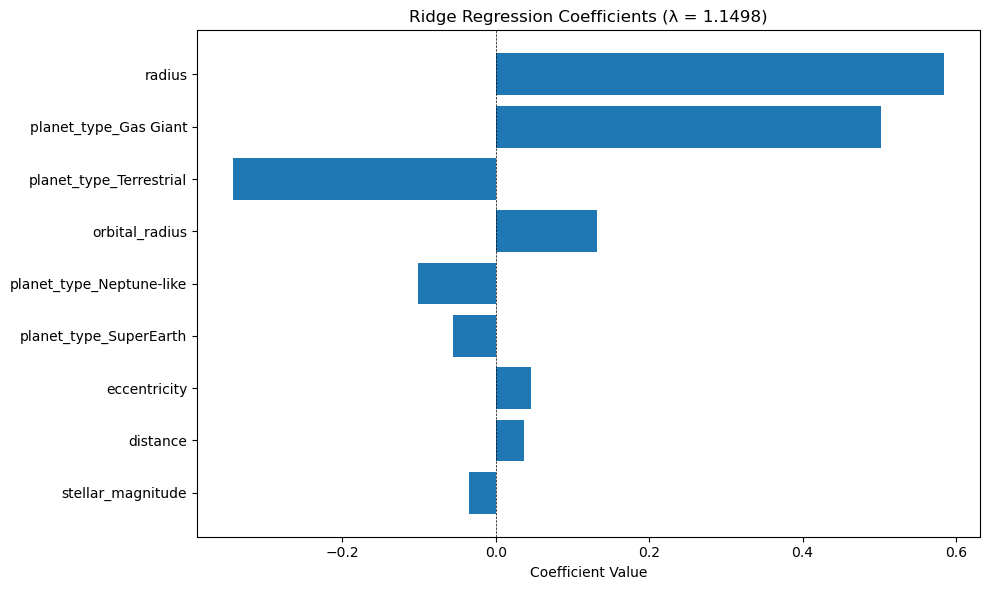

,Feature,Coefficient
4,radius,0.584909
5,planet_type_Gas Giant,0.501919
8,planet_type_Terrestrial,-0.343299
2,orbital_radius,0.131955
6,planet_type_Neptune-like,-0.101124
7,planet_type_SuperEarth,-0.055640
3,eccentricity,0.045324
0,distance,0.036428
1,stellar_magnitude,-0.035470


In [91]:


# Feature names for regression (excluding 'mass' which is the target)
feature_names_planets = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius', 'planet_type_Gas Giant', 'planet_type_Neptune-like', 'planet_type_SuperEarth', 'planet_type_Terrestrial']
#feature_names = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius']

# Create DataFrame for coefficients
coeffs_df = pd.DataFrame({
    'Feature': feature_names_planets,
    'Coefficient': coeffs
}).sort_values('Coefficient', key=abs, ascending=False)

print("Ridge Regression Coefficients:")
print(coeffs_df.to_string(index=False))
print(f"\nIntercept: {intercept:.4f}")
print(f"Train Error (MSE): {train_error_scaled:.4f}")
print(f"Test Error (MSE): {test_error_scaled:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coeffs_df['Feature'], coeffs_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title(f'Ridge Regression Coefficients (λ = {optimal_lambda:.4f})')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the DataFrame
coeffs_df

As we observable on the plot there are clearly a few attributes that have a higher (in absolute value) coefficient. The most dominant is the coefficient for the radius. This is in line with our previous analysis, where we investigated the correlation between different numerical attributes. Here we observed that the target attribute (mass) has the strongest correlation with the radius attribute. The other 5 coefficients are signifcantly smaller which is again in sync with the observations from our correlation.
[correlation matrix comparison]

Moreover, it is also an interesting finding that the planet types have a meaningful influence. Particularly, the gas giants have a strong negative influence. This is in line with the expectation that gas giants have a smaller density than rocky planets. (https://pmc.ncbi.nlm.nih.gov/articles/PMC4156706/). As a direct consequence for such large gas planets the radius is going to be also large, but the information on its type 'rebalances' the weight estimation in the regression model with a strong negative direction: as the type also indirectly indicates that the planet is likely to have a smaller density. On the other hand it is clearly visible for the rocky planets that their type adds a positive nudge to the weight estimation, as their density is a lot higher.

We conclude that the coefficients are in line with our expectations which is also supported by our previous findings regarding the radius and literature on the planet types.

In [92]:
K1 = 10  # outer folds
K2 = 10  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.logspace(-5, 4, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

In [93]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1),
    # 'deep_ann': np.zeros(K1)
}
y_true = []
y_preds = {
    'baseline': [],
    'ridge': [],
    'ann': [],
    # 'deep_ann': []
}

In [94]:
optimal_hs = np.zeros(K1)
optimal_hs_deep = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [96]:
# Deep architecture with 3 hidden layers
class DeepANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(DeepANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [97]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-8, weight_decay=0.0, epochs=10, batch_size=32, verbose=False, deep=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Convert numpy arrays to torch tensors
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    
    if deep:
        model = DeepANN(X_train.shape[1], hidden_units).to(device)
    else:
        model = PredictorANN(X_train.shape[1], hidden_units).to(device)
        
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
        step_val_loss = criterion(model(X_val_t), y_val_t).item()
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {step_val_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    print(f"Validation Loss: {val_loss:.4f}")
    return val_loss, model


In [98]:
train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=32, 
                      lr=1e-3,epochs=20, batch_size=32, deep=True)

Validation Loss: 0.0997


(0.09970647841691971,
 DeepANN(
   (model): Sequential(
     (0): Linear(in_features=9, out_features=32, bias=True)
     (1): ReLU()
     (2): Linear(in_features=32, out_features=32, bias=True)
     (3): ReLU()
     (4): Linear(in_features=32, out_features=32, bias=True)
     (5): ReLU()
     (6): Linear(in_features=32, out_features=1, bias=True)
   )
 ))

In [99]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True, random_state=42)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_outer, X_test_outer, y_train_outer, y_test_outer, feature_scaler, mu_y, sigma_y = standardize_data(
        X_train_outer, X_test_outer, y_train_outer, y_test_outer,
        numerical_indices, encoded_indices
    )

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)
    y_preds['baseline'].append(y_pred_baseline)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True, random_state=42)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_pred = ridge_model.predict(X_test_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_pred) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error
    y_preds['ridge'].append(ridge_pred)

    # ----- INNER CV for ANN (PyTorch version) -----
    ann_val_errors = np.zeros(len(hidden_units))
    ann_val_errors_deep = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        inner_errors = []
        inner_errors_deep = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
            inner_errors.append(val_loss)

            val_loss, _ = train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=True)
            inner_errors_deep.append(val_loss)

        ann_val_errors[j] = np.mean(inner_errors)
        ann_val_errors_deep[j] = np.mean(inner_errors_deep)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    optimal_h_deep = hidden_units[np.argmin(ann_val_errors_deep)]
    optimal_hs_deep[outer_fold] = optimal_h_deep

    # Train final ANN model on full outer training set
    # _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
    #                                 hidden_units=optimal_h, lr=1e-3, epochs=10)
    _, ann_model = train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=optimal_h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    test_errors_outer['ann'][outer_fold] = ann_test_error
    y_preds['ann'].append(y_pred_t)


    # _, ann_model_deep = train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=optimal_h_deep, 
    #                   lr=1e-3,epochs=20, batch_size=32, deep=True)
    # ann_model_deep.eval()

    # device = next(ann_model_deep.parameters()).device  # get model’s device
    # #X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    # #y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    # with torch.no_grad():
    #     y_pred_t_deep = ann_model_deep(X_test_t).cpu().numpy().flatten()

    # ann_test_error_deep = mean_squared_error(y_test_outer, y_pred_t_deep)
    # test_errors_outer['deep_ann'][outer_fold] = ann_test_error_deep
    # y_preds['deep_ann'].append(y_pred_t_deep)

    y_true.append(y_test_outer)


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.14005e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.73716e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.4412e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.14005e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.7371

Validation Loss: 0.1538
Validation Loss: 0.9911
Validation Loss: 0.1356
Validation Loss: 0.1442
Validation Loss: 0.1511
Validation Loss: 0.1468
Validation Loss: 0.1968
Validation Loss: 0.1717
Validation Loss: 0.1459
Validation Loss: 0.9914
Validation Loss: 0.1324
Validation Loss: 0.9913
Validation Loss: 0.1376
Validation Loss: 0.9914
Validation Loss: 0.9914
Validation Loss: 0.1364
Validation Loss: 0.1915
Validation Loss: 0.9913
Validation Loss: 0.2021
Validation Loss: 0.1407
Validation Loss: 0.1014
Validation Loss: 0.1032
Validation Loss: 0.1018
Validation Loss: 0.1036
Validation Loss: 0.1035
Validation Loss: 0.1008
Validation Loss: 0.1030
Validation Loss: 0.1152
Validation Loss: 0.1092
Validation Loss: 0.1018
Validation Loss: 0.1012
Validation Loss: 0.1014
Validation Loss: 0.1057
Validation Loss: 0.1001
Validation Loss: 0.1064
Validation Loss: 0.1001
Validation Loss: 0.1006
Validation Loss: 0.1057
Validation Loss: 0.1038
Validation Loss: 0.1001
Validation Loss: 0.1024
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.10542e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.92446e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.37599e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.10542e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.924

Validation Loss: 0.1462
Validation Loss: 0.9915
Validation Loss: 0.1437
Validation Loss: 0.9913
Validation Loss: 0.1303
Validation Loss: 0.1392
Validation Loss: 0.1482
Validation Loss: 0.9913
Validation Loss: 0.1593
Validation Loss: 0.1722
Validation Loss: 0.1470
Validation Loss: 0.1450
Validation Loss: 0.1300
Validation Loss: 0.9912
Validation Loss: 0.1813
Validation Loss: 0.9912
Validation Loss: 0.1320
Validation Loss: 0.9913
Validation Loss: 0.1435
Validation Loss: 0.9914
Validation Loss: 0.1043
Validation Loss: 0.1028
Validation Loss: 0.1014
Validation Loss: 0.1059
Validation Loss: 0.1061
Validation Loss: 0.1000
Validation Loss: 0.1020
Validation Loss: 0.1019
Validation Loss: 0.1017
Validation Loss: 0.0992
Validation Loss: 0.1033
Validation Loss: 0.1057
Validation Loss: 0.1064
Validation Loss: 0.1006
Validation Loss: 0.1041
Validation Loss: 0.1062
Validation Loss: 0.1048
Validation Loss: 0.1022
Validation Loss: 0.1049
Validation Loss: 0.0992
Validation Loss: 0.1011
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.98678e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.02967e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.98678e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.02967e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.016

Validation Loss: 0.1393
Validation Loss: 0.1311
Validation Loss: 0.1257
Validation Loss: 0.1225
Validation Loss: 0.1562
Validation Loss: 0.1849
Validation Loss: 0.1327
Validation Loss: 0.9914
Validation Loss: 0.1300
Validation Loss: 0.9914
Validation Loss: 0.3235
Validation Loss: 0.1632
Validation Loss: 0.1325
Validation Loss: 0.9909
Validation Loss: 0.2093
Validation Loss: 0.9914
Validation Loss: 0.1452
Validation Loss: 0.9930
Validation Loss: 0.1231
Validation Loss: 0.9921
Validation Loss: 0.1107
Validation Loss: 0.1015
Validation Loss: 0.1045
Validation Loss: 0.1010
Validation Loss: 0.1056
Validation Loss: 0.0996
Validation Loss: 0.1021
Validation Loss: 0.1075
Validation Loss: 0.1007
Validation Loss: 0.1016
Validation Loss: 0.1032
Validation Loss: 0.0995
Validation Loss: 0.1013
Validation Loss: 0.1035
Validation Loss: 0.1036
Validation Loss: 0.1220
Validation Loss: 0.1049
Validation Loss: 0.0985
Validation Loss: 0.1056
Validation Loss: 0.1037
Validation Loss: 0.1053
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.14951e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.94405e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.16449e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.94405e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.179

Validation Loss: 0.1473
Validation Loss: 0.1253
Validation Loss: 0.1338
Validation Loss: 0.9900
Validation Loss: 0.1311
Validation Loss: 0.9914
Validation Loss: 0.1483
Validation Loss: 0.2041
Validation Loss: 0.2378
Validation Loss: 0.1627
Validation Loss: 0.1737
Validation Loss: 0.9916
Validation Loss: 0.1446
Validation Loss: 0.9910
Validation Loss: 0.1452
Validation Loss: 0.9913
Validation Loss: 0.2536
Validation Loss: 0.1460
Validation Loss: 0.1858
Validation Loss: 0.3549
Validation Loss: 0.1059
Validation Loss: 0.1006
Validation Loss: 0.1031
Validation Loss: 0.1046
Validation Loss: 0.1035
Validation Loss: 0.1001
Validation Loss: 0.1050
Validation Loss: 0.1037
Validation Loss: 0.1030
Validation Loss: 0.1050
Validation Loss: 0.1003
Validation Loss: 0.1029
Validation Loss: 0.1026
Validation Loss: 0.0995
Validation Loss: 0.1041
Validation Loss: 0.1027
Validation Loss: 0.1087
Validation Loss: 0.1010
Validation Loss: 0.1051
Validation Loss: 0.1060
Validation Loss: 0.1048
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.80919e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.49502e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.28907e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.38896e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.809

Validation Loss: 0.1288
Validation Loss: 0.1493
Validation Loss: 0.1282
Validation Loss: 0.1494
Validation Loss: 0.2869
Validation Loss: 0.9912
Validation Loss: 0.1504
Validation Loss: 0.9913
Validation Loss: 0.1400
Validation Loss: 0.9911
Validation Loss: 0.1506
Validation Loss: 0.1327
Validation Loss: 0.1579
Validation Loss: 0.9906
Validation Loss: 0.1256
Validation Loss: 0.1368
Validation Loss: 0.2543
Validation Loss: 0.9925
Validation Loss: 0.1334
Validation Loss: 0.9910
Validation Loss: 0.1052
Validation Loss: 0.1044
Validation Loss: 0.1064
Validation Loss: 0.0998
Validation Loss: 0.1057
Validation Loss: 0.1016
Validation Loss: 0.1035
Validation Loss: 0.1030
Validation Loss: 0.1054
Validation Loss: 0.1016
Validation Loss: 0.1037
Validation Loss: 0.0991
Validation Loss: 0.1043
Validation Loss: 0.1047
Validation Loss: 0.1073
Validation Loss: 0.1031
Validation Loss: 0.1051
Validation Loss: 0.0995
Validation Loss: 0.1069
Validation Loss: 0.0979
Validation Loss: 0.0999
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.45976e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.39952e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.77142e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.45976e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.414

Validation Loss: 0.1268
Validation Loss: 0.4681
Validation Loss: 0.1638
Validation Loss: 0.9913
Validation Loss: 0.1340
Validation Loss: 0.9910
Validation Loss: 0.1495
Validation Loss: 0.9906
Validation Loss: 0.1362
Validation Loss: 0.1504
Validation Loss: 0.1228
Validation Loss: 0.9911
Validation Loss: 0.1404
Validation Loss: 0.9911
Validation Loss: 0.1321
Validation Loss: 0.9916
Validation Loss: 0.6135
Validation Loss: 0.9920
Validation Loss: 0.1471
Validation Loss: 0.1558
Validation Loss: 0.1038
Validation Loss: 0.1003
Validation Loss: 0.1025
Validation Loss: 0.0999
Validation Loss: 0.1068
Validation Loss: 0.1016
Validation Loss: 0.1019
Validation Loss: 0.0996
Validation Loss: 0.1074
Validation Loss: 0.1030
Validation Loss: 0.1067
Validation Loss: 0.1024
Validation Loss: 0.1069
Validation Loss: 0.1054
Validation Loss: 0.1051
Validation Loss: 0.1023
Validation Loss: 0.1045
Validation Loss: 0.1064
Validation Loss: 0.1024
Validation Loss: 0.1022
Validation Loss: 0.1020
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.91255e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.14178e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.11973e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.99896e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.731

Validation Loss: 0.2825
Validation Loss: 0.9911
Validation Loss: 0.3409
Validation Loss: 0.1603
Validation Loss: 0.1378
Validation Loss: 0.9916
Validation Loss: 0.1416
Validation Loss: 0.9912
Validation Loss: 0.1238
Validation Loss: 0.9912
Validation Loss: 0.2181
Validation Loss: 0.9910
Validation Loss: 0.1433
Validation Loss: 0.9911
Validation Loss: 0.1545
Validation Loss: 0.9913
Validation Loss: 0.1353
Validation Loss: 0.9916
Validation Loss: 0.1432
Validation Loss: 0.9918
Validation Loss: 0.1062
Validation Loss: 0.1056
Validation Loss: 0.1044
Validation Loss: 0.1042
Validation Loss: 0.1080
Validation Loss: 0.1042
Validation Loss: 0.1042
Validation Loss: 0.1051
Validation Loss: 0.1037
Validation Loss: 0.1123
Validation Loss: 0.1081
Validation Loss: 0.1038
Validation Loss: 0.1069
Validation Loss: 0.1002
Validation Loss: 0.1048
Validation Loss: 0.0992
Validation Loss: 0.1042
Validation Loss: 0.1010
Validation Loss: 0.1059
Validation Loss: 0.0994
Validation Loss: 0.1004
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.26696e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.70732e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.27551e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.5155e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.2669

Validation Loss: 0.1450
Validation Loss: 0.9911
Validation Loss: 0.1293
Validation Loss: 0.9915
Validation Loss: 0.1362
Validation Loss: 0.9906
Validation Loss: 0.2073
Validation Loss: 0.9909
Validation Loss: 0.1284
Validation Loss: 0.1466
Validation Loss: 0.1349
Validation Loss: 0.9913
Validation Loss: 0.1358
Validation Loss: 0.9913
Validation Loss: 0.1377
Validation Loss: 0.9913
Validation Loss: 0.1618
Validation Loss: 0.9915
Validation Loss: 0.1513
Validation Loss: 0.9917
Validation Loss: 0.1055
Validation Loss: 0.1024
Validation Loss: 0.1059
Validation Loss: 0.1021
Validation Loss: 0.1055
Validation Loss: 0.1024
Validation Loss: 0.1015
Validation Loss: 0.1006
Validation Loss: 0.1023
Validation Loss: 0.1016
Validation Loss: 0.1043
Validation Loss: 0.1098
Validation Loss: 0.1052
Validation Loss: 0.1010
Validation Loss: 0.1020
Validation Loss: 0.0996
Validation Loss: 0.1046
Validation Loss: 0.1048
Validation Loss: 0.1062
Validation Loss: 0.1009
Validation Loss: 0.1031
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.59355e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.48958e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.81686e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.59355e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.489

Validation Loss: 0.1732
Validation Loss: 0.9907
Validation Loss: 0.1251
Validation Loss: 0.9912
Validation Loss: 0.1740
Validation Loss: 0.1673
Validation Loss: 0.2610
Validation Loss: 0.9911
Validation Loss: 0.1296
Validation Loss: 0.9907
Validation Loss: 0.1323
Validation Loss: 0.9913
Validation Loss: 0.1546
Validation Loss: 0.1365
Validation Loss: 0.1481
Validation Loss: 0.1443
Validation Loss: 0.1457
Validation Loss: 0.9911
Validation Loss: 0.1496
Validation Loss: 0.9912
Validation Loss: 0.1101
Validation Loss: 0.1051
Validation Loss: 0.1064
Validation Loss: 0.1030
Validation Loss: 0.1088
Validation Loss: 0.1071
Validation Loss: 0.1008
Validation Loss: 0.1029
Validation Loss: 0.1027
Validation Loss: 0.1051
Validation Loss: 0.1007
Validation Loss: 0.1023
Validation Loss: 0.1024
Validation Loss: 0.1026
Validation Loss: 0.1038
Validation Loss: 0.1010
Validation Loss: 0.1012
Validation Loss: 0.1053
Validation Loss: 0.1017
Validation Loss: 0.1075
Validation Loss: 0.1019
Validation Loss:

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.44655e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.97638e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.94498e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.44655e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.976

Validation Loss: 0.1753
Validation Loss: 0.1515
Validation Loss: 0.1959
Validation Loss: 0.9913
Validation Loss: 0.1669
Validation Loss: 0.9906
Validation Loss: 0.1278
Validation Loss: 0.9913
Validation Loss: 0.1429
Validation Loss: 0.9913
Validation Loss: 0.3531
Validation Loss: 0.1569
Validation Loss: 0.2423
Validation Loss: 0.1859
Validation Loss: 0.1348
Validation Loss: 0.9901
Validation Loss: 0.1498
Validation Loss: 0.9911
Validation Loss: 0.1300
Validation Loss: 0.9924
Validation Loss: 0.1047
Validation Loss: 0.1022
Validation Loss: 0.1050
Validation Loss: 0.0999
Validation Loss: 0.1041
Validation Loss: 0.1009
Validation Loss: 0.1010
Validation Loss: 0.1051
Validation Loss: 0.1067
Validation Loss: 0.0975
Validation Loss: 0.1089
Validation Loss: 0.1014
Validation Loss: 0.1052
Validation Loss: 0.1071
Validation Loss: 0.1049
Validation Loss: 0.1004
Validation Loss: 0.1037
Validation Loss: 0.1013
Validation Loss: 0.1071
Validation Loss: 0.1042
Validation Loss: 0.1033
Validation Loss:

In [100]:
y_true = np.concatenate(y_true)


In [101]:
y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

In [102]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    # 'h* (Deep ANN)': optimal_hs_deep,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann'],
    # 'Deep ANN Test Error': test_errors_outer['deep_ann']
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1         1.389495      64.0             1.004958          0.094577        0.081776
    2         0.596362      64.0             0.979225          0.136373        0.120473
    3         2.120951     128.0             1.002592          0.124897        0.101307
    4         0.390694     128.0             0.961333          0.111764        0.084072
    5         1.389495     128.0             0.979475          0.060712        0.047200
    6         2.120951     128.0             0.985716          0.110195        0.081005
    7         1.389495     128.0             0.913133          0.099695        0.082133
    8         0.910298      64.0             0.950523          0.091406        0.080110
    9         0.596362     128.0             1.178448          0.099752        0.077859
   10         0.390694      64.0             1.053989          0.120536  

In [103]:
import scipy.stats as st
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # 4.1) Calculate estimated error, z_hat, as the mean loss across all samples
    ### BEGIN SOLUTION
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    ### END SOLUTION
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 4.2) Insert solution from task 3.6 here
    ### BEGIN SOLUTION
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    ### END SOLUTION
    
    # 4.3) Insert solution from task 3.7 here
    ### BEGIN SOLUTION
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    ### END SOLUTION

    # 4.4) Calculate the p-value for the two-sided test using the t-distribution
    ### BEGIN SOLUTION
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value
    ### END SOLUTION

    return z_hat, CI, p_value

In [104]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_storage = {
    'ridge_ann': [],
    'ann_baseline': [],
    'ridge_baseline': []
}

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["ann"], l2_loss, alpha=alpha)
setup1_storage['ridge_ann'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and ANN: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ridge_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ann"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ann_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between ANN and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

Difference in loss between Ridge and ANN: 
z_hat: 0.0195, 
CI: [0.0161, 0.0229], 
p-value: 1.7258985612161786e-28
Difference in loss between Ridge and Baseline: 
z_hat: -0.8959, 
CI: [-0.9378, -0.8541], 
p-value: 4.74856e-319
Difference in loss between ANN and Baseline: 
z_hat: -0.9154, 
CI: [-0.9579, -0.8729], 
p-value: 2.47e-322
